# **Step 1: Import Required Libraries**

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Print success message
print("Libraries imported successfully!")


Libraries imported successfully!


# **Step 2: Download and Inspect Data**

In [21]:
# Download Google stock data from Yahoo Finance
data = yf.download('GOOG', start='2010-01-01', end='2025-01-01')

# Display the first few rows of the dataset
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG
Date                                                             
2010-01-04  15.536651  15.605068  15.474429  15.541608   78541293
2010-01-05  15.468232  15.563670  15.407498  15.547309  120638494
2010-01-06  15.078298  15.514588  15.031198  15.514588  159744526
2010-01-07  14.727283  15.121432  14.691338  15.106558  257533695
2010-01-08  14.923613  14.954103  14.603584  14.675224  189680313


# **Step 3: Preprocess Data (Normalization & Create Time Windows)**

In [22]:
# Extract 'Close' prices for prediction
df = data[['Close']]
print("Data extracted successfully!")

# Normalize the data using MinMaxScaler (scaling data to range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])
print("Data normalized successfully!")

def create_dataset(data, time_step=60):
    """
    Creates a dataset for LSTM by splitting the data into input (X) and target (y).
    X consists of the past `time_step` days' closing prices to predict the next day's price.

    Parameters:
    - data: The normalized input data.
    - time_step: The number of previous days to use for predicting the next day's closing price.

    Returns:
    - X: The input data (features) shaped for LSTM (samples, time steps, features).
    - y: The target values (next day's closing price).
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Features: past `time_step` days
        y.append(data[i + time_step, 0])      # Target: next day's closing price
    return np.array(X), np.array(y)

# Set time step to 60 (i.e., look at the past 60 days)
time_step = 60
X, y = create_dataset(scaled_data, time_step)
print(f"Dataset created with {X.shape[0]} samples.")

# Reshape data for LSTM input: (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Data extracted successfully!
Data normalized successfully!
Dataset created with 3713 samples.
Training data shape: (2970, 60, 1), Test data shape: (743, 60, 1)


# **Step 4: Define the LSTM Model**

In [23]:
# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units, return sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer with 50 units, no return sequences
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Dense layer with 1 unit for predicting the next day's stock price
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary to view the architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 5: Train the Model**

In [24]:
# Train the model on training data, with validation on the test data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0155 - val_loss: 0.0013
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 8.2410e-04 - val_loss: 0.0012
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 5.5208e-04 - val_loss: 0.0011
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 5.4829e-04 - val_loss: 0.0016
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 6.6337e-04 - val_loss: 0.0011
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 4.7123e-04 - val_loss: 0.0012
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 6.4330e-04 - val_loss: 0.0013
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 4.4129e-04 - val_loss: 0.0010
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 4.2205e-04 - val_loss: 8.4115e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 4.3264e-04 - val_loss: 0.0011


# **Step 6: Make Predictions and Evaluate the Model**

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


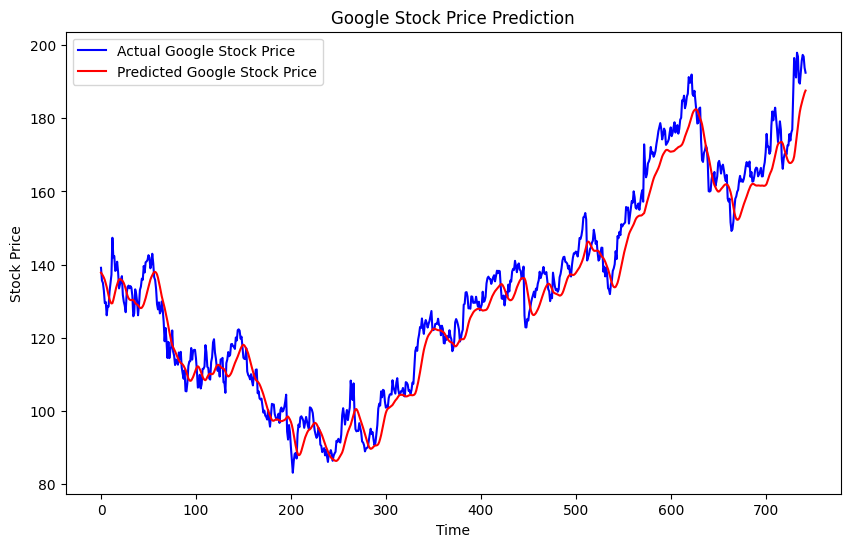

In [25]:
# Predict on the test set
predicted_stock_price = model.predict(X_test)

# Inverse scaling of predictions and actual values (to bring back to original range)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Google Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# **Step 7: Calculate Model Performance (RMSE)**

In [27]:
# Calculate RMSE (Root Mean Squared Error) to evaluate model performance
rmse = np.sqrt(np.mean(np.square(y_test_actual - predicted_stock_price)))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 6.068754460395426
